In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 16.9MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 133kB 41.1MB/s 
     |████████████████████████████████| 7.4MB 44.4MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
ERROR: botocore 1.20.56 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
% matplotlib inline


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## **Spam** Datasets

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
X_train = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/X_train_fSP.pkl')
X_test = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/X_test_fSP.pkl')
y_train = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/y_train_fSP.pkl')
y_test = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SPAM/y_test_fSP.pkl')


Mounted at /content/gdrive


## Data preprocessing

In [ ]:
X_train = X_train.drop(['text', 'cleaned_text'], axis=1)
X_test = X_test.drop(['text', 'cleaned_text'], axis=1)


In [ ]:
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
X_train['cleaned_text_full'] = ["[CLS] " + str(x) + " [SEP]" for x in X_train['cleaned_text_full']]
X_test['cleaned_text_full'] = ["[CLS] " + str(x) + " [SEP]" for x in X_test['cleaned_text_full']]

In [ ]:
cleaned_tokens = X_train.cleaned_text_full.values
labels = y_train.values

## Inputs

Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in cleaned_tokens]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 926522.40B/s]


Tokenize the first sentence:
['[CLS]', 'thinking', 'of', 'breathing', 'new', 'life', 'into', 'your', 'business', 'start', 'from', 'rev', '##amp', '##ing', 'its', 'front', 'end', 'logo', 'and', 'vis', '##ua', '##i', 'identity', 'lo', '##q', '##ode', '##nti', '##ty', 'offers', 'creative', 'custom', 'design', 'of', 'lo', '##q', '##os', 'station', '##ery', 'and', 'web', 'sites', 'under', 'our', 'careful', 'hand', 'these', 'powerful', 'market', '##in', '##q', 'too', '##is', 'wii', '##l', 'bring', 'a', 'breath', 'of', 'fresh', 'air', 'into', 'your', 'business', 'and', 'make', 'you', 'stand', 'out', 'am', '##on', '##q', 'the', 'competitors', 'you', 'are', 'just', 'a', 'ci', '##ick', 'away', 'from', 'your', 'future', 'success', 'ci', '##ick', 'here', 'to', 'see', 'the', 'samples', 'of', 'our', 'artwork', 'check', 'our', 'prices', 'and', 'hot', 'offers', '[SEP]']


In [ ]:
# Set the maximum sequence length
MAX_LEN = 50

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (764 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (659 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (766 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (654 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (708 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
input_ids = np.hstack((X_train.drop(['cleaned_text_full'],axis=1).values, input_ids))

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=1, test_size=0.33)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=1, test_size=0.33)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels,dtype=torch.long)
validation_labels = torch.tensor(validation_labels,dtype=torch.long)
train_masks = torch.tensor(train_masks,dtype=torch.long)
validation_masks = torch.tensor(validation_masks,dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 32

# Create an iterator of data with torch DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:14<00:00, 29006912.22B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
import tensorflow as tf

optimizer = BertAdam(optimizer_grouped_parameters,
                     loss = 'mse',
                     metrics=[tf.keras.metrics.AUC()],
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode 
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch.tensor(b_input_ids).to(torch.int64)
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch.tensor(b_input_ids).to(torch.int64)

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.1439359935762171


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Epoch:  33%|███▎      | 1/3 [03:33<07:07, 213.78s/it]

Validation Accuracy: 0.9683476394849786
Train loss: 0.03291409854716483


Epoch:  67%|██████▋   | 2/3 [07:07<03:33, 213.69s/it]

Validation Accuracy: 0.9742489270386266
Train loss: 0.01433588414353943


Epoch: 100%|██████████| 3/3 [10:40<00:00, 213.62s/it]

Validation Accuracy: 0.9808208154506438


## Training Evaluation

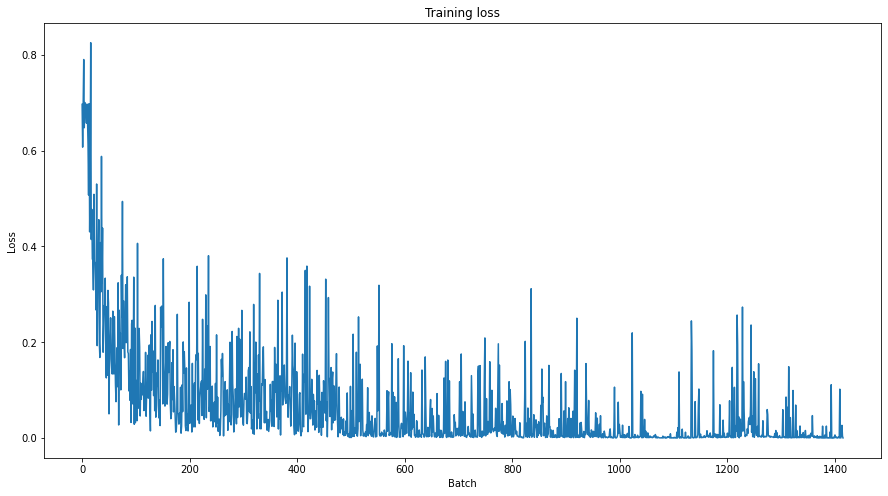

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

In [ ]:
sentences = X_test.cleaned_text_full.values
labels = y_test.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 50

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids = np.hstack((X_test.drop(['cleaned_text_full'],axis=1).values, input_ids))
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (529 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (706 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (645 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (525 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (661 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [ ]:
%%time
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  b_input_ids = torch.tensor(b_input_ids).to(torch.int64)

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


CPU times: user 22 s, sys: 13.2 s, total: 35.2 s
Wall time: 35.1 s


In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [ ]:
print("Test Results:")
print("ROC-AUC Score: ", roc_auc_score(flat_true_labels, flat_predictions))
print("Accuracy Score: ", accuracy_score(flat_true_labels, flat_predictions))
print("Confusion Matrix: ", confusion_matrix(flat_true_labels, flat_predictions))
print("F1 score: ", f1_score(flat_true_labels, flat_predictions))

Test Results:
ROC-AUC Score:  0.981805769685396
Accuracy Score:  0.9820607590372307
Confusion Matrix:  [[6041   97]
 [ 102 4853]]
F1 score:  0.9799091367995961


### Reviewing False Positives

In [ ]:
X_test[flat_true_labels < flat_predictions].cleaned_text_full

41125    [CLS] another example known to devotees of the...
16541    [CLS] greetings from amazon com we thought you...
33988    [CLS] please click on the link below to review...
35903    [CLS] title when push comes to shove natural g...
35825    [CLS] lisa fawcett has invited you to a premie...
                               ...                        
34745    [CLS] hi mell jim stopped by dilbert com and t...
12530    [CLS] indians r poor but india is not a poor c...
12930    [CLS] if you wish to find out more about the m...
24920    [CLS] http www worth com magazine index html [...
18956    [CLS] hello i just received your message are s...
Name: cleaned_text_full, Length: 97, dtype: object

### Reviewing False Negatives

In [ ]:
X_test[flat_true_labels > flat_predictions].cleaned_text_full.head(50)

36811    [CLS] find local movie times and trailers on y...
5602     [CLS] hi this is amy we will be sending you a ...
6025     [CLS] dating i have had two of these only star...
26950    [CLS] lennie sion and discomforts thanks and b...
24816                             [CLS] full article [SEP]
41287    [CLS] don ted i guess i owe you guys lunch who...
4072     [CLS] life has never been this much fun and gr...
29524    [CLS] hey prescott are you looking for that ex...
14661    [CLS] as you know election time is not the bes...
4730     [CLS] kick off a new season with wks free goal...
41794    [CLS] horizon publishing would like to invite ...
2292     [CLS] a networks allow companies to bill for s...
473      [CLS] dear sir mdm good day and how are you i ...
2529     [CLS] would you like to see my xxx pics they a...
31732    [CLS] get started today we will resolve your t...
30550    [CLS] project tic toc technical manuel the is ...
13683              [CLS] don t be like that tororane [SE